In [ ]:
import pandas as pd

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import os.path

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
!cd /content/drive/MyDrive/CMPE255_ASL_PROJECT

In [ ]:
!unzip -q /content/drive/MyDrive/CMPE255_ASL_PROJECT/Data.zip

In [ ]:
!ls asl_alphabet_train

asl_alphabet_train


In [ ]:
!ls asl_alphabet_train

asl_alphabet_train


Filter out corrupted images (bad encoded)

In [ ]:
import os

num_skipped=0
for folder_name in ("A","B","C","D","E","F","G","H","I","J","K"):
    folder_path = os.path.join("/content/asl_alphabet_train/asl_alphabet_train",folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)



Deleted 0 images


Dataset Generation

-----------------------------------------------------------------------------------------------

In [ ]:
def get_paths_labels(path, allowed_extension="jpg"):
        global Path
        images_dir = Path(path)
        
        filepaths = pd.Series((images_dir.glob(fr'**/*.{allowed_extension}'))).astype(str)
        filepaths.name = "path"
        
        labels = filepaths.str.split("/")[:].str[-2]
        labels.name = "label"

        # Concatenate filepaths and labels
        df = pd.concat([filepaths, labels], axis=1)

        # Shuffle the DataFrame and reset index
        df = df.sample(frac=1).reset_index(drop = True)
        return df

In [ ]:
# Read image
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:


# Visualize samples
def visualize_samples(datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    images = filepaths.apply(get_image).reset_index(drop=True)
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(labels[sample_index])
            ax[i,j].set_axis_off()
    plt.show()
    



In [ ]:
# Process image (input) for the model
def process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img


# Make classifications & visualize results
def visualize_classifications(model, datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    
    images = filepaths.apply(get_image).reset_index(drop=True)
    processed_images = np.vstack(images.apply(process).to_numpy()[:])
    
    y_pred = classes[np.argmax(model.predict(processed_images, verbose=0), axis=1)]
    y_true = labels
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(f"Y true({y_true[sample_index]}) | Y pred ({y_pred[sample_index]})")
            ax[i,j].set_axis_off()
    plt.show()

In [ ]:


# Read datasets

# Create dataframe of {paths, labels}
train_df = get_paths_labels('/content/asl_alphabet_train/asl_alphabet_train')



In [ ]:
# Classes counts
print("Classes counts")
counts = train_df.iloc[:,1].value_counts().sort_index()
print(counts.head(counts.shape[0]))
print(f"\n\nDataset size = {counts.sum()} samples")

Classes counts
A          3000
B          3000
C          3000
D          3000
E          3000
F          3000
G          3000
H          3000
I          3000
J          3000
K          3000
L          3000
M          3000
N          3000
O          3000
P          3000
Q          3000
R          3000
S          3000
T          3000
U          3000
V          3000
W          3000
X          3000
Y          3000
Z          3000
del        3000
nothing    3000
space      3000
Name: label, dtype: int64


Dataset size = 87000 samples


In [ ]:


# Preprocess data

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    validation_split=0.2,
    horizontal_flip = True,
    brightness_range=(0.75, 1.3),
    zoom_range=0.2
)


train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='validation'
)



Found 69600 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.


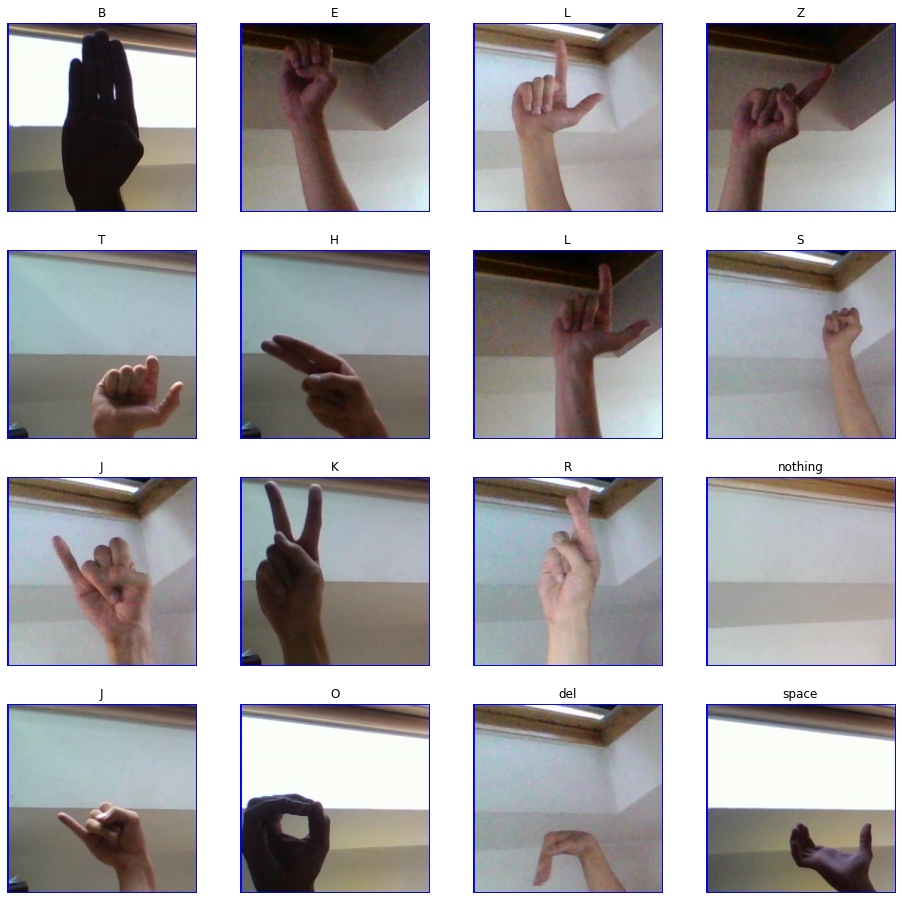

In [ ]:
visualize_samples(train_images)

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal")
    ]
)

In [ ]:
# Neural network architecture

pretrainedModel = tf.keras.applications.MobileNet(
    input_shape=(224, 224, 3),
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel.trainable = False

inputs = pretrainedModel.input

model = tf.keras.models.Sequential([
              data_augmentation,
              tf.keras.applications.MobileNet(input_shape=(224, 224, 3),include_top=False,weights='imagenet',pooling='avg'),
              
              tf.keras.layers.Dense(128, activation='relu'),
              tf.keras.layers.Dense(128, activation='relu'),
              tf.keras.layers.Dense(30, activation='softmax')
                                    
])

optimizer_adam = tf.keras.optimizers.Adam(learning_rate = 0.005)


In [ ]:
# Compile model
model.compile(
    optimizer=optimizer_adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Reference: 

https://keras.io/examples/vision/image_classification_from_scratch/